In [ ]:
import torch
print(torch.__version__)

2.3.0+cu121


In [ ]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!pip install kaggle

!kaggle datasets download -d iamsouravbanerjee/animal-image-dataset-90-different-animals

!unzip animal-image-dataset-90-different-animals.zip

Streaming output truncated to the last 5000 lines.
  inflating: animals/animals/bison/73b10839bc.jpg  
  inflating: animals/animals/bison/74dc1dd32a.jpg  
  inflating: animals/animals/bison/75ab166a7d.jpg  
  inflating: animals/animals/bison/79e1610d01.jpg  
  inflating: animals/animals/bison/7ba5eee91f.jpg  
  inflating: animals/animals/bison/7d214aab4b.jpg  
  inflating: animals/animals/bison/7f2ef9ab03.jpg  
  inflating: animals/animals/bison/82ec723a4f.jpg  
  inflating: animals/animals/bison/85e145af6c.jpg  
  inflating: animals/animals/bison/862e2c6379.jpg  
  inflating: animals/animals/bison/87a5c700ad.jpg  
  inflating: animals/animals/bison/88b723ce90.jpg  
  inflating: animals/animals/bison/8c3af742c3.jpg  
  inflating: animals/animals/bison/8e34044b98.jpg  
  inflating: animals/animals/bison/8e6adbdc40.jpg  
  inflating: animals/animals/bison/8fce80d5ba.jpg  
  inflating: animals/animals/bison/961a895686.jpg  
  inflating: animals/animals/bison/984a5b583d.jpg  
  inflating: 

In [ ]:
%%writefile my_dataset.py
from PIL import Image
import torch
from torch.utils.data import Dataset


class MyDataSet(Dataset):

    def __init__(self, images_path: list, images_class: list, transform=None):
        self.images_path = images_path
        self.images_class = images_class
        self.transform = transform

    def __len__(self):
        return len(self.images_path)

    def __getitem__(self, item):
        img = Image.open(self.images_path[item]).convert('RGB')

        label = self.images_class[item]

        if self.transform is not None:
            img = self.transform(img)

        return img, label

    @staticmethod
    def collate_fn(batch):
        images, labels = tuple(zip(*batch))

        images = torch.stack(images, dim=0)
        labels = torch.as_tensor(labels)
        return images, labels

Writing my_dataset.py


In [ ]:
%%writefile utils.py
import os
import sys
import json
import pickle
import random

import torch
from tqdm import tqdm

import matplotlib.pyplot as plt


def read_split_data(root: str, val_rate: float = 0.2):
    random.seed(0)
    assert os.path.exists(root), "dataset root: {} does not exist.".format(root)


    flower_class = [cla for cla in os.listdir(root) if os.path.isdir(os.path.join(root, cla))]

    flower_class.sort()
    class_indices = dict((k, v) for v, k in enumerate(flower_class))
    json_str = json.dumps(dict((val, key) for key, val in class_indices.items()), indent=4)
    with open('class_indices.json', 'w') as json_file:
        json_file.write(json_str)

    train_images_path = []
    train_images_label = []
    val_images_path = []
    val_images_label = []
    every_class_num = []
    supported = [".jpg", ".JPG", ".png", ".PNG"]

    for cla in flower_class:
        cla_path = os.path.join(root, cla)

        images = [os.path.join(root, cla, i) for i in os.listdir(cla_path)
                  if os.path.splitext(i)[-1] in supported]

        images.sort()

        image_class = class_indices[cla]

        every_class_num.append(len(images))

        val_path = random.sample(images, k=int(len(images) * val_rate))

        for img_path in images:
            if img_path in val_path:
                val_images_path.append(img_path)
                val_images_label.append(image_class)
            else:
                train_images_path.append(img_path)
                train_images_label.append(image_class)

    print("{} images were found in the dataset.".format(sum(every_class_num)))
    print("{} images for training.".format(len(train_images_path)))
    print("{} images for validation.".format(len(val_images_path)))
    assert len(train_images_path) > 0, "number of training images must greater than 0."
    assert len(val_images_path) > 0, "number of validation images must greater than 0."

    plot_image = False
    if plot_image:

        plt.bar(range(len(flower_class)), every_class_num, align='center')

        plt.xticks(range(len(flower_class)), flower_class)

        for i, v in enumerate(every_class_num):
            plt.text(x=i, y=v + 5, s=str(v), ha='center')

        plt.xlabel('image class')

        plt.ylabel('number of images')

        plt.title('flower class distribution')
        plt.show()

    return train_images_path, train_images_label, val_images_path, val_images_label


def plot_data_loader_image(data_loader):
    batch_size = data_loader.batch_size
    plot_num = min(batch_size, 4)

    json_path = './class_indices.json'
    assert os.path.exists(json_path), json_path + " does not exist."
    json_file = open(json_path, 'r')
    class_indices = json.load(json_file)

    for data in data_loader:
        images, labels = data
        for i in range(plot_num):
            img = images[i].numpy().transpose(1, 2, 0)
            img = (img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]) * 255
            label = labels[i].item()
            plt.subplot(1, plot_num, i+1)
            plt.xlabel(class_indices[str(label)])
            plt.xticks([])
            plt.yticks([])
            plt.imshow(img.astype('uint8'))
        plt.show()


def write_pickle(list_info: list, file_name: str):
    with open(file_name, 'wb') as f:
        pickle.dump(list_info, f)


def read_pickle(file_name: str) -> list:
    with open(file_name, 'rb') as f:
        info_list = pickle.load(f)
        return info_list


def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    loss_function = torch.nn.CrossEntropyLoss()
    accu_loss = torch.zeros(1).to(device)
    accu_num = torch.zeros(1).to(device)
    optimizer.zero_grad()

    sample_num = 0
    data_loader = tqdm(data_loader, file=sys.stdout)
    for step, data in enumerate(data_loader):
        images, labels = data
        sample_num += images.shape[0]

        pred = model(images.to(device))
        pred_classes = torch.max(pred, dim=1)[1]
        accu_num += torch.eq(pred_classes, labels.to(device)).sum()
        labels = labels.to(device)
        loss = loss_function(pred, labels)
        loss.backward()
        accu_loss += loss.detach()

        data_loader.desc = "[train epoch {}] loss: {:.3f}, acc: {:.3f}".format(epoch,
                                                                               accu_loss.item() / (step + 1),
                                                                               accu_num.item() / sample_num)

        if not torch.isfinite(loss):
            print('WARNING: non-finite loss, ending training ', loss)
            sys.exit(1)

        optimizer.step()
        optimizer.zero_grad()

    return accu_loss.item() / (step + 1), accu_num.item() / sample_num


@torch.no_grad()
def evaluate(model, data_loader, device, epoch):
    loss_function = torch.nn.CrossEntropyLoss()

    model.eval()

    accu_num = torch.zeros(1).to(device)
    accu_loss = torch.zeros(1).to(device)

    sample_num = 0
    data_loader = tqdm(data_loader, file=sys.stdout)
    for step, data in enumerate(data_loader):
        images, labels = data
        sample_num += images.shape[0]

        pred = model(images.to(device))
        pred_classes = torch.max(pred, dim=1)[1]
        accu_num += torch.eq(pred_classes, labels.to(device)).sum()

        loss = loss_function(pred, labels.to(device))
        accu_loss += loss

        data_loader.desc = "[valid epoch {}] loss: {:.3f}, acc: {:.3f}".format(epoch,
                                                                               accu_loss.item() / (step + 1),
                                                                               accu_num.item() / sample_num)

    return accu_loss.item() / (step + 1), accu_num.item() / sample_num

Writing utils.py


In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 20.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
import timm
from pprint import pprint
model_names = timm.list_models()
pprint(model_names)

['bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_large_patch16_224',
 'botnet26t_256',
 'botnet50ts_256',
 'caformer_b36',
 'caformer_m36',
 'caformer_s18',
 'caformer_s36',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_medium',
 'coat_lite_medium_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_small',
 'coat_tiny',
 'coatnet_0_224',
 'coatnet_0_rw_224',
 'coatnet_1_224',
 'coatnet_1_rw_224',
 'coatnet_2_224',
 'coatnet_2_rw_224',
 'coatnet_3_224',
 'coatnet_3_rw_224',
 'coatnet_4_224',
 'coatnet_5_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_cc_224',
 'coatnet_nano_rw_224',
 'coatnet_pico_rw_224',
 'coatnet_rmlp_0_rw_224',
 'coatnet_rmlp_1_rw2_224',
 'coatnet_rmlp_1_r

In [ ]:
%%writefile train.py
import os
import argparse

import torch
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms

from my_dataset import MyDataSet
from utils import read_split_data, train_one_epoch, evaluate
import timm


def main(args):
    device = torch.device(args.device if torch.cuda.is_available() else "cpu")

    if os.path.exists("./weights") is False:
        os.makedirs("./weights")

    tb_writer = SummaryWriter()

    train_images_path, train_images_label, val_images_path, val_images_label = read_split_data(args.data_path)

    img_size = 224
    data_transform = {
        "train": transforms.Compose([transforms.RandomResizedCrop(img_size),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
        "val": transforms.Compose([transforms.Resize(int(img_size * 1.143)),
                                   transforms.CenterCrop(img_size),
                                   transforms.ToTensor(),
                                   transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])}

    train_dataset = MyDataSet(images_path=train_images_path,
                              images_class=train_images_label,
                              transform=data_transform["train"])

    val_dataset = MyDataSet(images_path=val_images_path,
                            images_class=val_images_label,
                            transform=data_transform["val"])

    batch_size = args.batch_size
    nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])
    print('Using {} dataloader workers every process'.format(nw))
    train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size,
                                               shuffle=True,
                                               pin_memory=True,
                                               num_workers=nw,
                                               collate_fn=train_dataset.collate_fn)

    val_loader = torch.utils.data.DataLoader(val_dataset,
                                             batch_size=batch_size,
                                             shuffle=False,
                                             pin_memory=True,
                                             num_workers=nw,
                                             collate_fn=val_dataset.collate_fn)

    model = timm.create_model('convnext_small_in22k',pretrained=True,num_classes = args.num_classes).to(device)
    if args.weights != "":
        assert os.path.exists(args.weights), "weights file: '{}' not exist.".format(args.weights)
        weights_dict = torch.load(args.weights, map_location=device)["model"]

        for k in list(weights_dict.keys()):
            if "head" in k:
                del weights_dict[k]
        print(model.load_state_dict(weights_dict, strict=False))

    if args.freeze_layers:
        for name, para in model.named_parameters():
            if "head" not in name:
                para.requires_grad_(False)
            else:
                print("training {}".format(name))

    pg = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.AdamW(pg, lr=args.lr, weight_decay=5E-2)

    for epoch in range(args.epochs):
        # train
        train_loss, train_acc = train_one_epoch(model=model,
                                                optimizer=optimizer,
                                                data_loader=train_loader,
                                                device=device,
                                                epoch=epoch)

        # validate
        val_loss, val_acc = evaluate(model=model,
                                     data_loader=val_loader,
                                     device=device,
                                     epoch=epoch)

        tags = ["train_loss", "train_acc", "val_loss", "val_acc", "learning_rate"]
        tb_writer.add_scalar(tags[0], train_loss, epoch)
        tb_writer.add_scalar(tags[1], train_acc, epoch)
        tb_writer.add_scalar(tags[2], val_loss, epoch)
        tb_writer.add_scalar(tags[3], val_acc, epoch)
        tb_writer.add_scalar(tags[4], optimizer.param_groups[0]["lr"], epoch)

        torch.save(model.state_dict(), "./weights/model-{}.pth".format(epoch))


if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--num_classes', type=int, default=5)
    parser.add_argument('--epochs', type=int, default=10)
    parser.add_argument('--batch-size', type=int, default=8)
    parser.add_argument('--lr', type=float, default=0.0001)
    parser.add_argument('--data-path', type=str,
                        default="/data/flower_photos")

    parser.add_argument('--weights', type=str, default='',
                        help='initial weights path')
    parser.add_argument('--freeze-layers', type=bool, default=False)
    parser.add_argument('--device', default='cuda:0', help='device id (i.e. 0 or 0,1 or cpu)')

    opt = parser.parse_args()

    main(opt)

Writing train.py


In [ ]:
!python train.py --data-path /content/animals/animals --num_classes 90 --epochs 20 --batch-size 80

2024-05-27 02:16:50.450480: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-27 02:16:50.450542: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-27 02:16:50.569104: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-27 02:16:50.798327: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-27 02:16:52.228163: W tensorflow/compiler/tf2

using cuda:0 device.
class: antelope     prob: 2.6e-05
class: badger       prob: 1.38e-05
class: bat          prob: 2.5e-05
class: bear         prob: 1.47e-05
class: bee          prob: 1.44e-05
class: beetle       prob: 3.81e-05
class: bison        prob: 3.77e-06
class: boar         prob: 1.96e-05
class: butterfly    prob: 3.12e-05
class: cat          prob: 1.74e-05
class: caterpillar   prob: 4.26e-05
class: chimpanzee   prob: 7.08e-06
class: cockroach    prob: 4.63e-05
class: cow          prob: 9.87e-06
class: coyote       prob: 1.94e-05
class: crab         prob: 6.53e-05
class: crow         prob: 7.07e-06
class: deer         prob: 1.38e-05
class: dog          prob: 1.15e-05
class: dolphin      prob: 1.49e-05
class: donkey       prob: 1.98e-05
class: dragonfly    prob: 3.62e-05
class: duck         prob: 1.99e-05
class: eagle        prob: 2.67e-05
class: elephant     prob: 7.37e-06
class: flamingo     prob: 4.04e-05
class: fly          prob: 0.000132
class: fox          prob: 9.23e-06


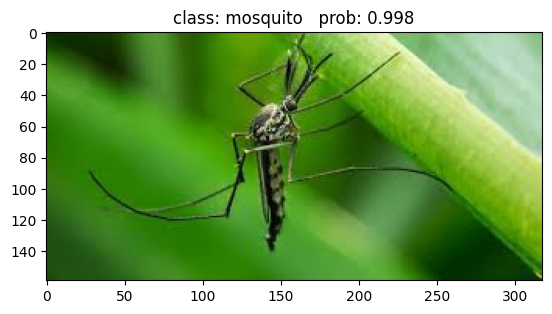

In [ ]:
import os
import json

import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt



def main():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"using {device} device.")
    num_classes = 90
    model = timm.create_model('convnext_small_in22k', pretrained=True,num_classes= num_classes).to(device)

    img_size = 224
    data_transform = transforms.Compose(
        [transforms.Resize(int(img_size)),
         transforms.CenterCrop(img_size),
         transforms.ToTensor()])

    img_path = "/content/animals/animals/mosquito/0014c2d720.jpg"
    assert os.path.exists(img_path), "file: '{}' dose not exist.".format(img_path)
    img = Image.open(img_path)
    plt.imshow(img)
    img = data_transform(img)
    img = torch.unsqueeze(img, dim=0)

    json_path = './class_indices.json'
    assert os.path.exists(json_path), "file: '{}' dose not exist.".format(json_path)

    with open(json_path, "r") as f:
        class_indict = json.load(f)

    model_weight_path = "/content/weights/model-19.pth"
    model.load_state_dict(torch.load(model_weight_path, map_location=device))
    model.eval()
    with torch.no_grad():
        output = torch.squeeze(model(img.to(device))).cpu()
        predict = torch.softmax(output, dim=0)
        predict_cla = torch.argmax(predict).numpy()

    print_res = "class: {}   prob: {:.3}".format(class_indict[str(predict_cla)],
                                                 predict[predict_cla].numpy())
    plt.title(print_res)
    for i in range(len(predict)):
        print("class: {:10}   prob: {:.3}".format(class_indict[str(i)],
                                                  predict[i].numpy()))
    plt.show()


if __name__ == '__main__':
    main()